[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6)] [(0.5, 0.5), (2.5, 0.5), (4.5, 0.5), (1.5, 1.5), (3.5, 1.5), (5.5, 1.5), (0.5, 2.5), (2.5, 2.5), (4.5, 2.5), (1.5, 3.5), (3.5, 3.5), (5.5, 3.5), (0.5, 4.5), (2.5, 4.5), (4.5, 4.5), (1.5, 5.5), (3.5, 5.5), (5.5, 5.5), (1.5, -0.5), (3.5, -0.5), (5.5, -0.5), (0.5, 6.5), (2.5, 6.5), (4.5, 6.5)] [(1.5, 0.5), (3.5, 0.5), (5.5, 0.5), (0.5, 1.5), (2.5, 1.5), (4.5, 1.5), (1.5, 2.5), (3.5, 2.5), (5.5, 2.5), (0.5, 3.5), (2.5, 3.5), (4.5, 3.5), (1.5, 4.5), (3.5, 4.5), (5.5, 4.5), (0.5, 5.5), (2.5, 5.5), (4.5, 5.5), (-0.5, 0.5), (-0.5, 2.5), (-0.5, 4.5), (6.5, 1.5), (6.5, 3.5), (6.5, 5.5)]
[(0, 0), (1, 0), (2, 0)

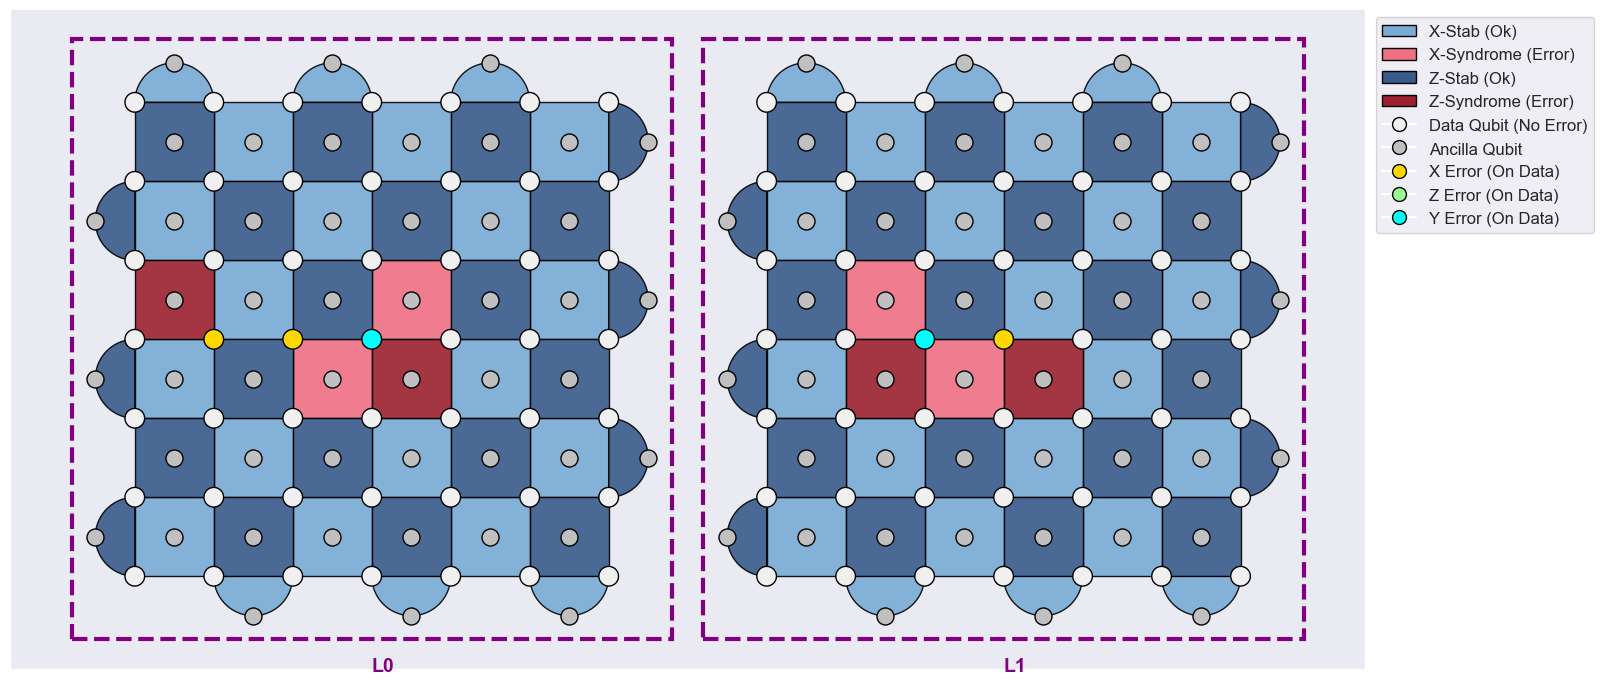

In [14]:
from MultiSurfaceCode import MultiLogicalSurfaceCode

mlsc = MultiLogicalSurfaceCode(distance=7, num_logical_qubits=2)

x_errs = {
    "0": [46, 47, 48],   # Errors on first logical qubit patch
    "1": [144, 145]      # Errors on second logical qubit patch (indices are higher)
}

z_errs = {
    "0": [48], # just as a safety margin the dictionary 
    "1": [144]
}

mlsc.visualize(show_ancillas=True, show_indices=False, X_errors=x_errs, Z_errors=z_errs)

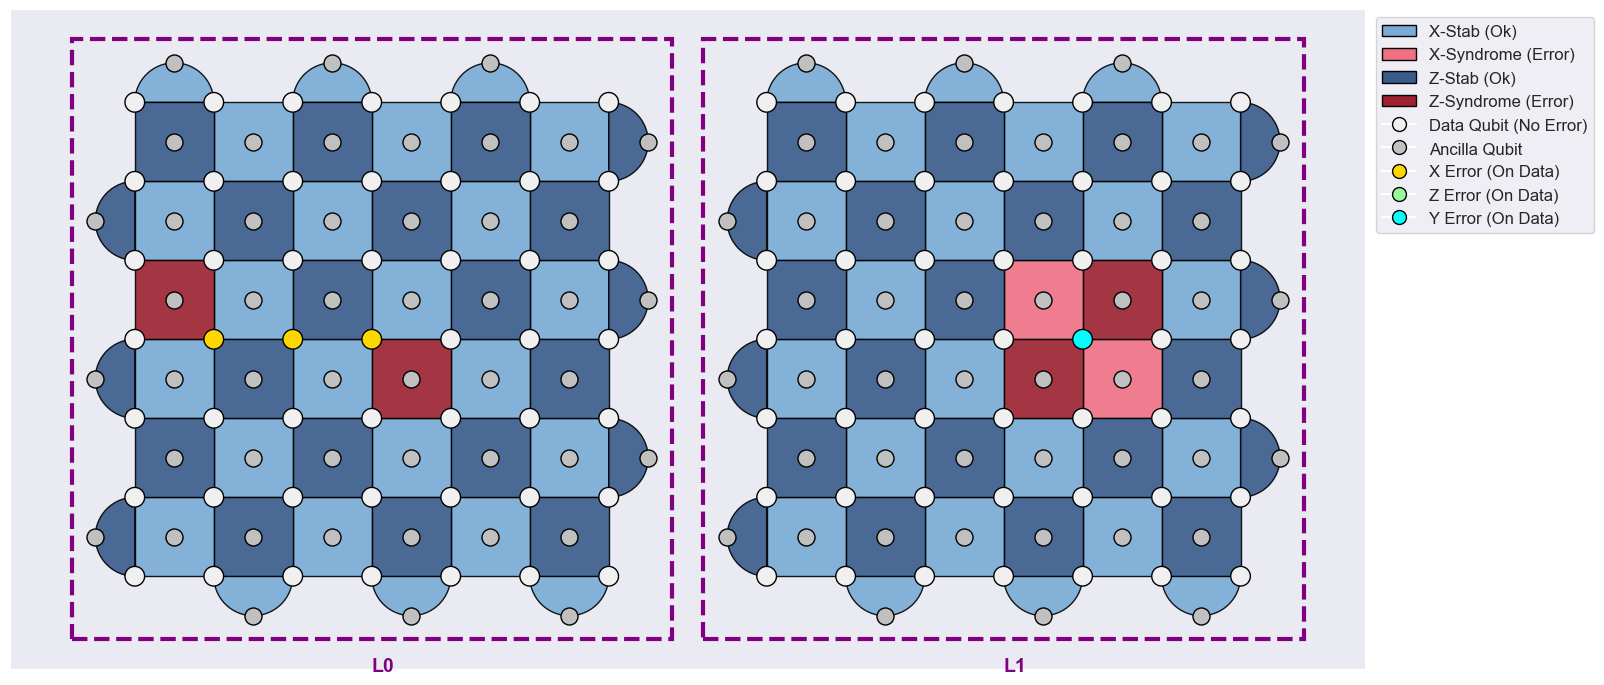

In [10]:
x_errs = {"0": [46, 47, 48], "1": [146] }
z_errs = {"0": [38], "1": [146]}

mlsc.visualize(show_ancillas=True, show_indices=False, X_errors=x_errs, Z_errors=z_errs)

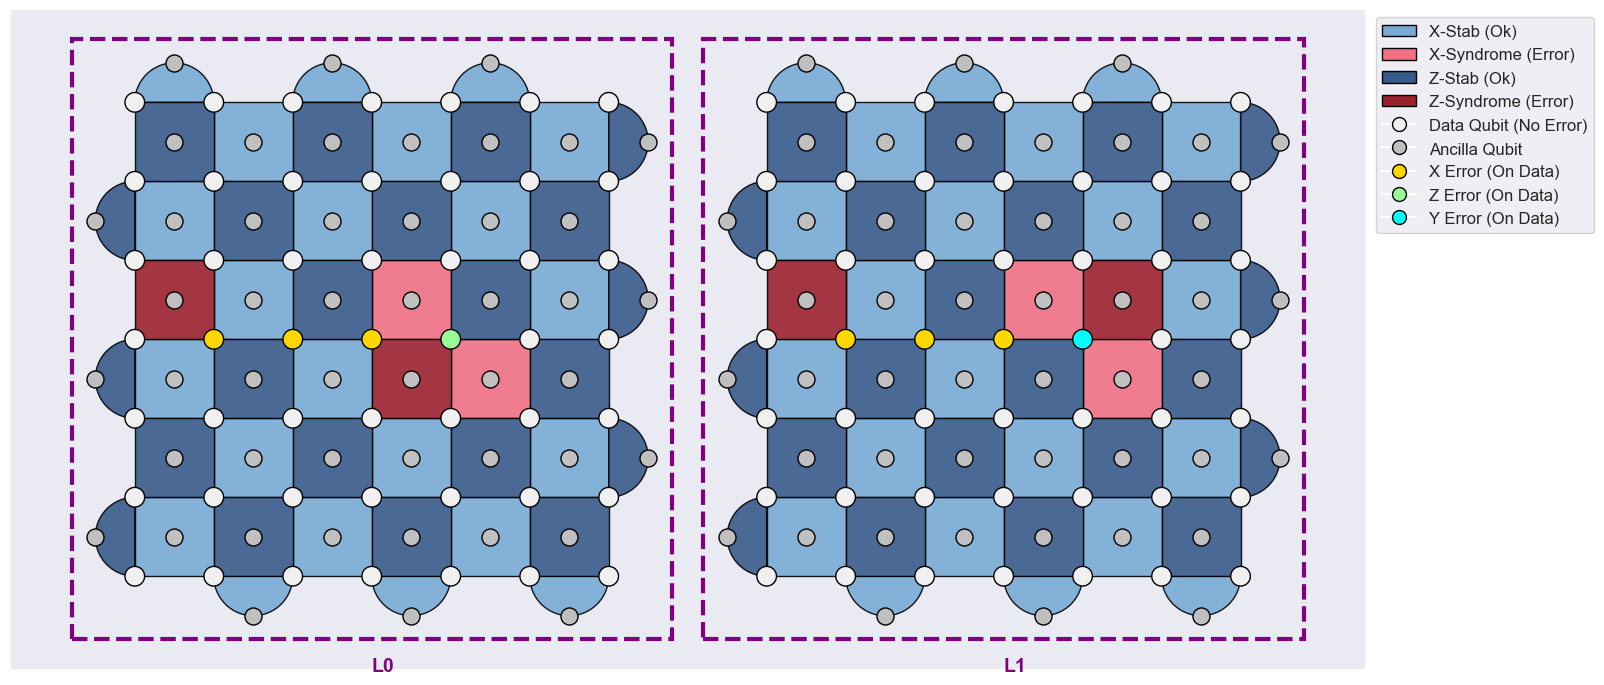

In [9]:
x_errs = {"0": [46, 47, 48], "1": [143,144, 145, 146] }
z_errs = {"0": [38, 49], "1": [146]}

mlsc.visualize(show_ancillas=True, show_indices=False, X_errors=x_errs, Z_errors=z_errs)

In [1]:
from surface_code import SurfaceCode
from typing import List
import numpy as np

sc = SurfaceCode(distance=7)

x_indices = [anc for anc in sc.stab_indices if sc.index_mapping[anc][1] == 'X_stab']
x_coords = [sc.index_mapping[anc][0] for anc in x_indices]
z_indices = [anc for anc in sc.stab_indices if sc.index_mapping[anc][1] == 'Z_stab']
z_coords = [sc.index_mapping[anc][0] for anc in z_indices]

print("X Stabilizer Coordinates:", x_coords, end='\n')
print("X Stabilizer indices:", x_indices, end='\n')
print("Z Stabilizer Coordinates:", z_coords, end='\n')
print("Z Stabilizer indices:", z_indices, end='\n')

data_qubit_indices = [sc.inverse_mapping[q] for q in sc.qubit_coords if sc.index_mapping[sc.inverse_mapping[q]][1] == 'data']
print("Data Qubit Coordinates:", data_qubit_indices, end='\n')

x_err_at: List[int] = [46,47,48]
syndrome = sc.get_syndrome(x_errors=x_err_at, z_errors=x_err_at)
print("Syndrome:", syndrome, end='\n')

# sc.plot()

X Stabilizer Coordinates: [(0.5, 0.5), (0.5, 2.5), (0.5, 4.5), (0.5, 6.5), (1.5, -0.5), (1.5, 1.5), (1.5, 3.5), (1.5, 5.5), (2.5, 0.5), (2.5, 2.5), (2.5, 4.5), (2.5, 6.5), (3.5, -0.5), (3.5, 1.5), (3.5, 3.5), (3.5, 5.5), (4.5, 0.5), (4.5, 2.5), (4.5, 4.5), (4.5, 6.5), (5.5, -0.5), (5.5, 1.5), (5.5, 3.5), (5.5, 5.5)]
X Stabilizer indices: [11, 39, 67, 94, 0, 25, 53, 81, 13, 41, 69, 95, 1, 27, 55, 83, 15, 43, 71, 96, 2, 29, 57, 85]
Z Stabilizer Coordinates: [(-0.5, 0.5), (-0.5, 2.5), (-0.5, 4.5), (0.5, 1.5), (0.5, 3.5), (0.5, 5.5), (1.5, 0.5), (1.5, 2.5), (1.5, 4.5), (2.5, 1.5), (2.5, 3.5), (2.5, 5.5), (3.5, 0.5), (3.5, 2.5), (3.5, 4.5), (4.5, 1.5), (4.5, 3.5), (4.5, 5.5), (5.5, 0.5), (5.5, 2.5), (5.5, 4.5), (6.5, 1.5), (6.5, 3.5), (6.5, 5.5)]
Z Stabilizer indices: [10, 38, 66, 24, 52, 80, 12, 40, 68, 26, 54, 82, 14, 42, 70, 28, 56, 84, 16, 44, 72, 30, 58, 86]
Data Qubit Coordinates: [3, 4, 5, 6, 7, 8, 9, 17, 18, 19, 20, 21, 22, 23, 31, 32, 33, 34, 35, 36, 37, 45, 46, 47, 48, 49, 50, 51,

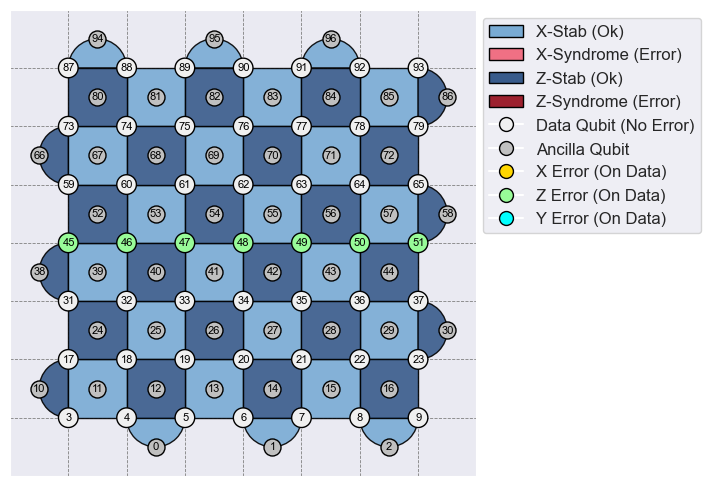

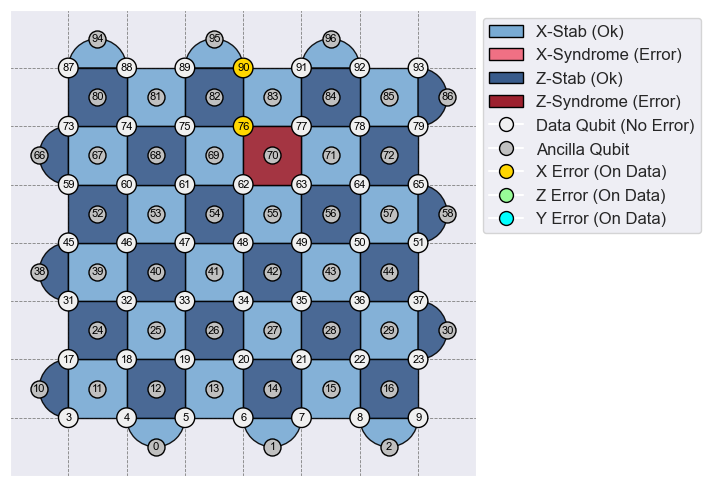

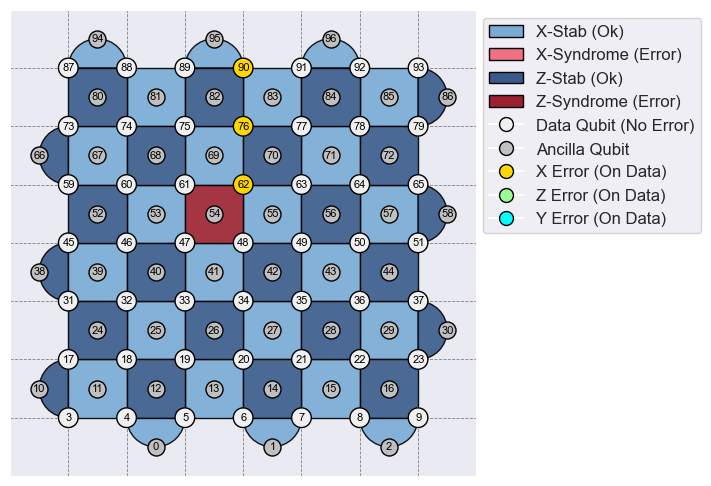

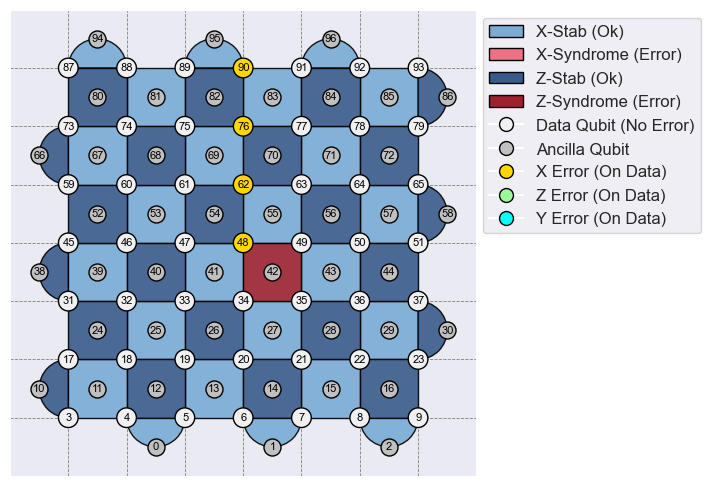

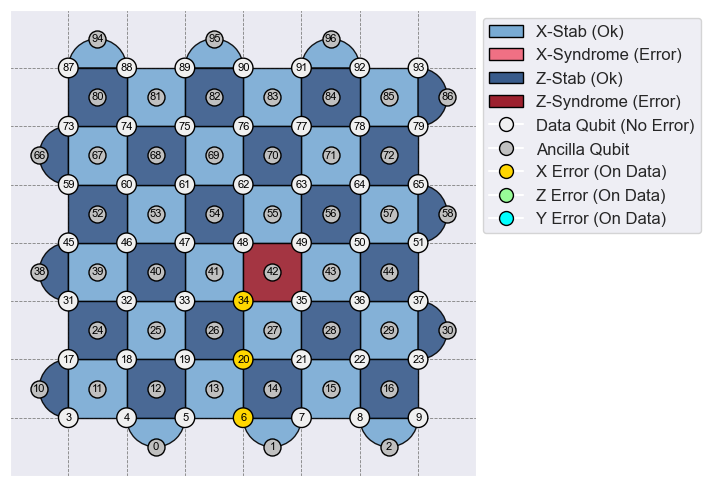

In [14]:
# sc.visualize_results(show_ancillas=True, show_index=True)
sc.visualize_results(x_err=[], z_err=[45,46,47,48,49,50,51], show_ancillas=True, show_index=True)
sc.visualize_results(z_err=[], x_err=[90, 76], show_ancillas=True, show_index=True)
sc.visualize_results(z_err=[], x_err=[90, 76, 62], show_ancillas=True, show_index=True)
sc.visualize_results(z_err=[], x_err=[90, 76, 62, 48], show_ancillas=True, show_index=True)

sc.visualize_results(z_err=[], x_err=[34, 20, 6], show_ancillas=True, show_index=True)
# sc.visualize_results(z_err=[48], x_err=[], show_ancillas=True, show_index=True)

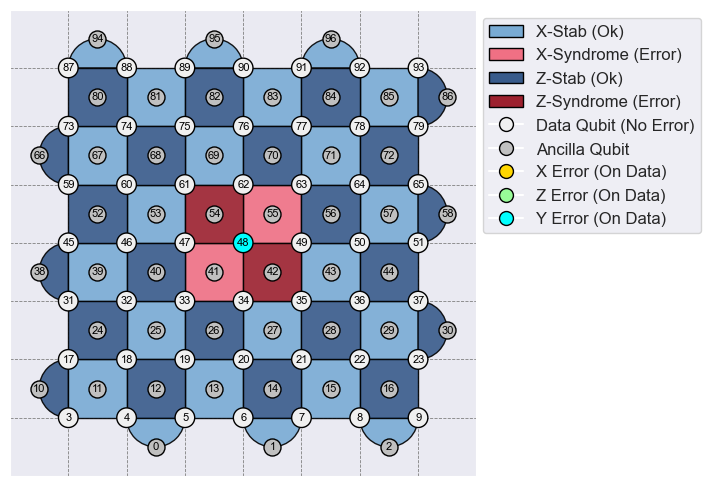

In [7]:
sc.visualize_results(z_err=[48], x_err=[48], show_ancillas=True, show_index=True)


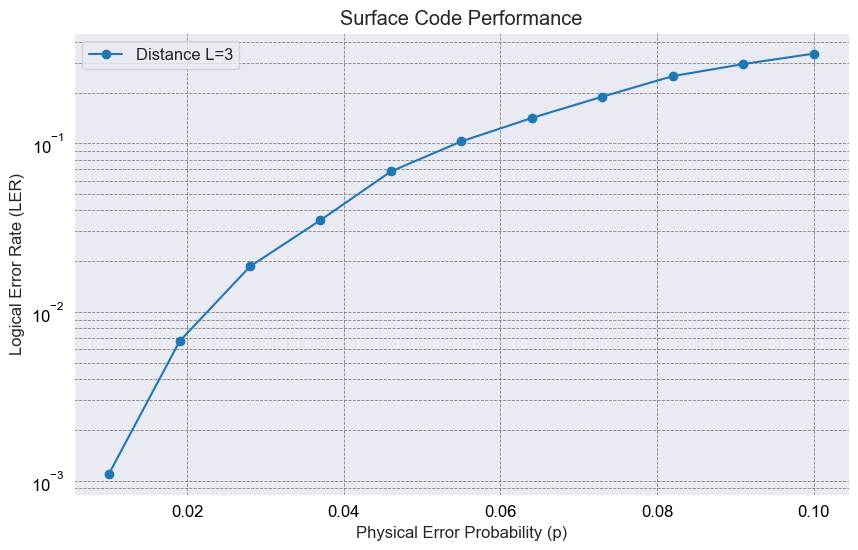

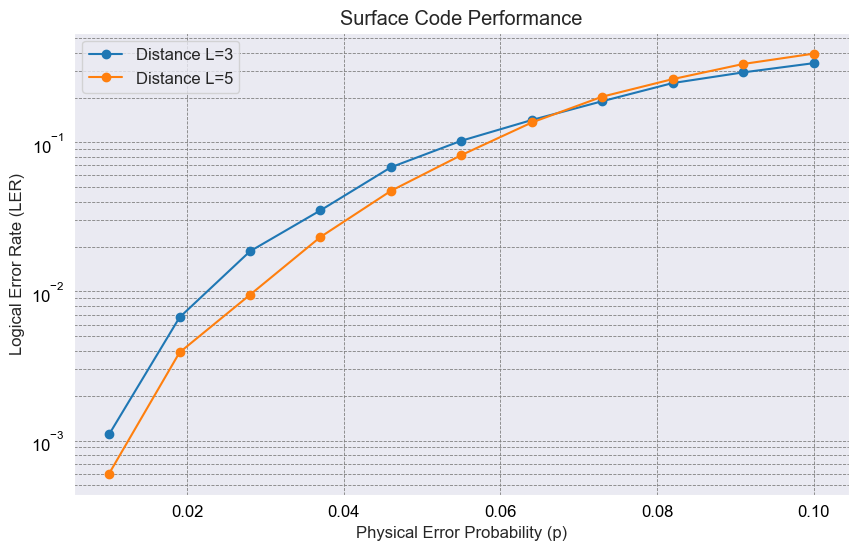

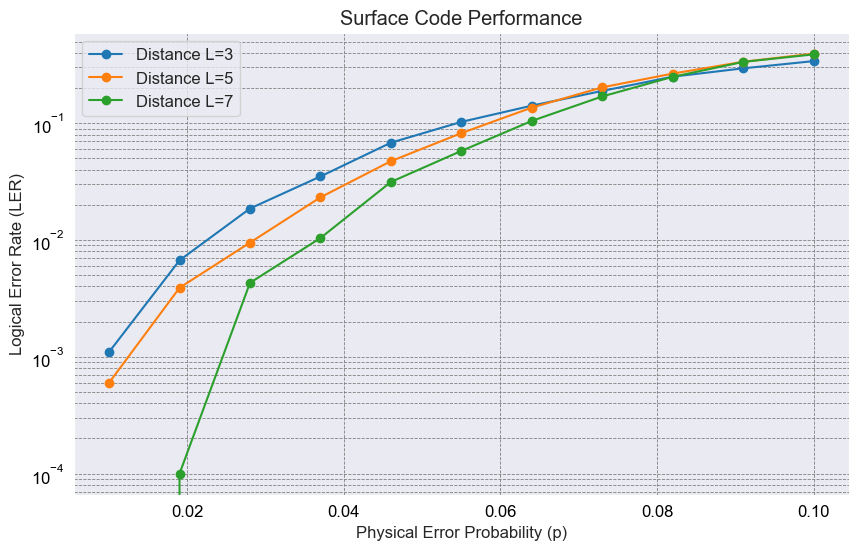

In [9]:
import numpy as np
import matplotlib as mpl
import seaborn as sns

# At some point I should use a std as well for the logical error rates
# like this: std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
# from the https://github.com/oscarhiggott/PyMatching/blob/master/docs/toric-code-example.ipynb
# in cell 12 of the introductory notebook.

Ls = [3,5,7]
ps = np.linspace(0.01, 0.1, 11)

results = {}

for L in Ls:
    SC = SurfaceCode(distance=L)
    res_L = []
    for p in ps:
        SC.build_in_stim(rounds=L, depolarize_prob=p)
        ler, syndrome, obs, preds = SC.run_with_pymatching(shots=10000)
        res_L.append(ler)
    results[L] = np.array(res_L)

    import matplotlib.pyplot as plt

    # Apply scientific plot styling
    sns.set_style("darkgrid")
    mpl.rcParams.update(
        {
            "font.size": 12,
            "grid.color": "0.5",
            "grid.linestyle": "--",
            "grid.linewidth": 0.6,
            "xtick.color": "black",
            "ytick.color": "black",
        }
    )

    # Create the plot
    plt.figure(figsize=(10, 6))

    for L, lers in results.items():
        plt.plot(ps, lers, marker='o', linestyle='-', label=f'Distance L={L}')

    # Set plot labels and title
    plt.xlabel("Physical Error Probability (p)")
    plt.ylabel("Logical Error Rate (LER)")
    plt.title("Surface Code Performance")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
   

Round 1 (Raw): [False False False False False  True False  True  True  True  True  True
 False False False False False False False False False False False False]
Round 2 (Raw): [False False False False  True  True False False  True  True  True  True
 False False False False False  True  True False False False False False]
Round 3 (Raw): [False False False False  True  True False False  True  True  True  True
 False False False False False  True  True False False False False False]
Round 4 (Raw): [False False False False  True  True False False  True  True  True  True
 False False False False False  True  True False False False False False]
Syndrome (1-2 Diff): [False False False False  True False False  True False False False False
 False False False False False  True  True False False False False False]
Syndrome (1-3 Diff): [False False False False  True False False  True False False False False
 False False False False False  True  True False False False False False]
Syndrome (1-4 Di

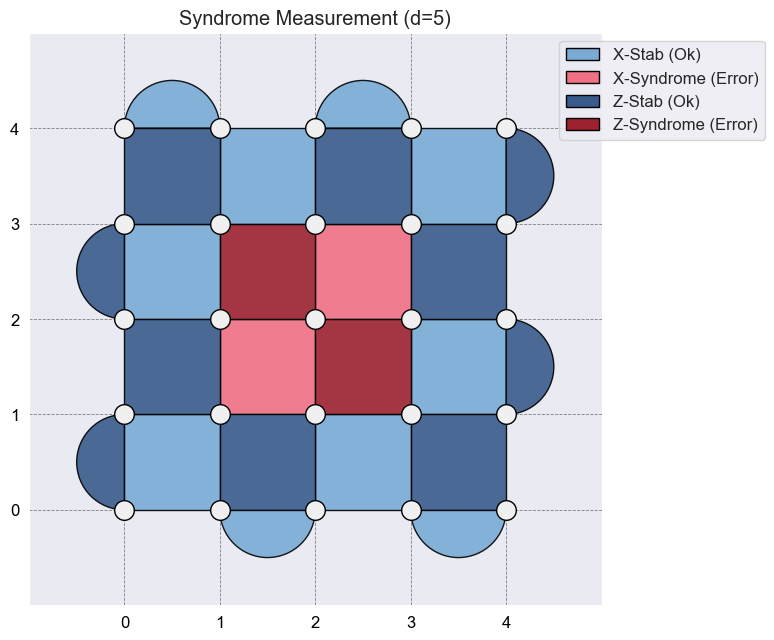

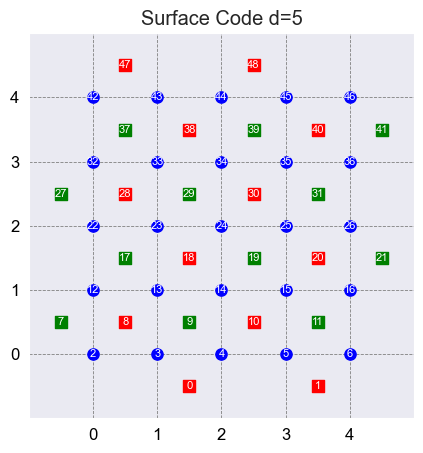

      /----------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /-----------------------------------------------------------------------------------------------------------------------

In [10]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)
sc.build_in_stim(rounds=4, depolarize_prob=0.02)

results = sc.run_simulation(shots=1)
single_shot = results[0]

# Calculate number of ancillas
num_ancillas = len(sc.x_stabilisers_coords) + len(sc.z_stabilisers_coords)

# Split results into rounds
round_1 = single_shot[:num_ancillas]
round_2 = single_shot[num_ancillas:2*num_ancillas]
round_3 = single_shot[2*num_ancillas:3*num_ancillas]
round_4 = single_shot[3*num_ancillas:4*num_ancillas]

syndrome_change = round_1 ^ round_2

print("Round 1 (Raw):", round_1)
print("Round 2 (Raw):", round_2)
print("Round 3 (Raw):", round_3)
print("Round 4 (Raw):", round_4)
print("Syndrome (1-2 Diff):", syndrome_change)
print("Syndrome (1-3 Diff):", round_1^round_3)
print("Syndrome (1-4 Diff):", round_1^round_4)

# Visualize the CHANGE, not the raw round
sc.visualize_results(round_1^round_2, show_ancillas=False)
sc.plot()
sc.diagram()

0 (1.5, -0.5) X_stab -> [(2.0, 0.0), (1.0, 0.0)]
inverse mapping: [(2.0, 0.0), (1.0, 0.0)] -> [4, 3]

1 (3.5, -0.5) X_stab -> [(4.0, 0.0), (3.0, 0.0)]
inverse mapping: [(4.0, 0.0), (3.0, 0.0)] -> [6, 5]

7 (-0.5, 0.5) Z_stab -> [(0.0, 1.0), (0.0, 0.0)]
inverse mapping: [(0.0, 1.0), (0.0, 0.0)] -> [12, 2]

8 (0.5, 0.5) X_stab -> [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)]
inverse mapping: [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)] -> [13, 12, 3, 2]

9 (1.5, 0.5) Z_stab -> [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)]
inverse mapping: [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)] -> [14, 4, 13, 3]

10 (2.5, 0.5) X_stab -> [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)]
inverse mapping: [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)] -> [15, 14, 5, 4]

11 (3.5, 0.5) Z_stab -> [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)]
inverse mapping: [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)] -> [16, 6, 15, 5]

17 (0.5, 1.5) Z_stab -> [(1.0, 2.0), (1.0, 1.0), (0.0, 2.0), (0

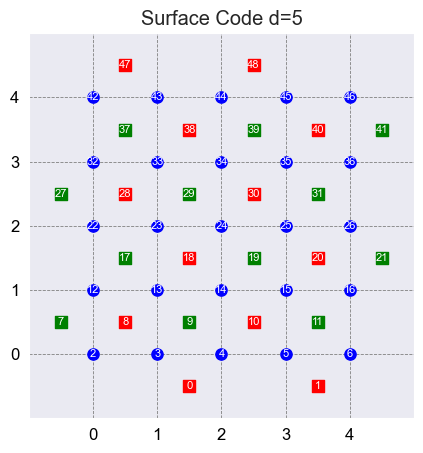

Sorted stabilizers:
8 ((0.5, 0.5), 'X_stab')
28 ((0.5, 2.5), 'X_stab')
47 ((0.5, 4.5), 'X_stab')
0 ((1.5, -0.5), 'X_stab')
18 ((1.5, 1.5), 'X_stab')
38 ((1.5, 3.5), 'X_stab')
10 ((2.5, 0.5), 'X_stab')
30 ((2.5, 2.5), 'X_stab')
48 ((2.5, 4.5), 'X_stab')
1 ((3.5, -0.5), 'X_stab')
20 ((3.5, 1.5), 'X_stab')
40 ((3.5, 3.5), 'X_stab')
7 ((-0.5, 0.5), 'Z_stab')
27 ((-0.5, 2.5), 'Z_stab')
17 ((0.5, 1.5), 'Z_stab')
37 ((0.5, 3.5), 'Z_stab')
9 ((1.5, 0.5), 'Z_stab')
29 ((1.5, 2.5), 'Z_stab')
19 ((2.5, 1.5), 'Z_stab')
39 ((2.5, 3.5), 'Z_stab')
11 ((3.5, 0.5), 'Z_stab')
31 ((3.5, 2.5), 'Z_stab')
21 ((4.5, 1.5), 'Z_stab')
41 ((4.5, 3.5), 'Z_stab')
Data qubits: [2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46]


In [ ]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)

# Build circuit for 2 rounds to allow comparison
sc.build_in_stim(rounds=4)
all_ids = list(sc.index_mapping.keys())

for anc in all_ids:
    coord, qtype = sc.index_mapping[anc]
    if qtype == 'data':
        continue
    neigh = sc.get_surrounding_data_qubits(coord)
    print(anc, coord, qtype, '->', neigh)
    sc.inverse_mapping
    print(f"inverse mapping: {neigh} -> {[sc.inverse_mapping[n] for n in neigh]}\n")

sc.plot()

print("Sorted stabilizers:")
stab_indices = sc.get_stabilisers(_as="idx") # type: ignore
        
stab_indices = sorted(  # otherwise Z and X stabilizers are measured in random order!
    stab_indices,
    key=lambda anc: (
        sc.index_mapping[anc][1],        # 'X_stab' or 'Z_stab'
        sc.index_mapping[anc][0][0],     # x-coordinate
        sc.index_mapping[anc][0][1],     # y-coordinate
    )
)
for anc in stab_indices:
    print(anc, sc.index_mapping[anc])

data_indices = [k for k, v in sc.index_mapping.items() if v[1] == 'data']
print("Data qubits:", data_indices)
